In [36]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
from collections import deque

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X

clear_output()

In [455]:
class Game:
    def __init__(self, coins, agents, max_duration=None):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
        
        if max_duration is None:
            self.max_duration = (coins.shape[0] + coins.shape[1]) * np.sum(coins)
        else:
            self.max_duration = max_duration
    
    @staticmethod
    def create_arena(shape, agent_names, coin_count=3):
        coins = np.zeros(shape)
        xs = np.random.choice(shape[0], coin_count)
        ys = np.random.choice(shape[1], coin_count)
        
        coins[xs, ys] = 1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [coins, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= self.max_duration:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    

In [456]:
import numpy as np
import tensorflow as tf

import time
from copy import copy

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Cropping2D, Concatenate
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import backend as K

from agent_code.tensor_agent.hyperparameters import hp

from agent_code.tensor_agent.loss import weighted_huber_loss, huber_loss
from agent_code.tensor_agent.layers import NoisyDense, VAMerge

from agent_code.tensor_agent.names import get_random_name

writers = {}

def getFileWriter(name='train', reset=False):
    if name not in writers or reset:
        writers[name] = tf.summary.FileWriter(f'tf-board/{name}/{time.time()}')

    return writers[name]

class Counter:
    def __init__(self, count=0):
        self.count = count

    def __iadd__(self, other):
        self.count += other
        return self.count

    def __mod__(self, other):
        return self.count % other

    def __repr__(self):
        return str(self.count)

    def __int__(self):
        return self.count



class FullModel:
    def __init__(self, input_shape, D, model_fn, family=None):
        self.input_shape = input_shape
        self.D = D

        #========================
        #  Define Model
        #========================

        # Define online and target models for Double Q-learning
        self.online, o_in, o_out = model_fn(input_shape, D)
        self.target, _, _ = model_fn(input_shape, D)

        
        #========================
        #  Define Training Update
        #========================
        action_holder = Input(shape=(1,), dtype='int32')  # in j=0,...,D-1
        reward_holder = Input(shape=(1,))
        weight_holder = Input(shape=(1,))
        
        # applies a mask to the outputs so that only the prediction for the chosen action is considered
        responsible_weight = tf.batch_gather(o_out, action_holder)
        
        loss = tf.losses.huber_loss(reward_holder, responsible_weight, weight_holder)

        summaries = []
        if family is None:
            family = get_random_name()
        self.family = family

        summaries.append(tf.summary.scalar('loss', loss, family=family))
        summaries.append(tf.summary.scalar('reward', tf.reduce_mean(reward_holder), family=family))

        optimizer = tf.train.AdamOptimizer(hp.learning_rate, epsilon=hp.adam_epsilon)
        update = optimizer.minimize(loss)

        merged_summary = tf.summary.merge(summaries)

        self.summary = merged_summary
        self.summary_frequency = 100
        
        self.errors=tf.abs(reward_holder-responsible_weight)
        self.input_ph = o_in
        self.o_out = o_out
        self.action_ph = action_holder
        self.reward_ph = reward_holder
        self.update_op = update
        self.weights = weight_holder

        self.steps = Counter()


    def update(self, inputs, actions, rewards, per_weights):
        sess = K.get_session()
        _, errors, summary = sess.run([self.update_op, self.errors, self.summary], feed_dict={
            self.input_ph: inputs,
            self.action_ph:actions,
            self.reward_ph:rewards,
            self.weights:per_weights
        })
        if (self.steps % self.summary_frequency == 0):
            getFileWriter('train').add_summary(summary, self.steps)

        self.steps += 1
        return errors

    def update_target(self):
        self.target.set_weights(self.online.get_weights())

    def save(self, file='my_model.h5'):
        self.online.save(file)

    def load_weights(self, file='my_model.h5'):
        print('loading weights')
        self.online.load_weights(file)
        self.target.load_weights(file)
        print('weights loaded')

    def set_weights(self, weights):
        self.online.set_weights(weights)
        self.target.set_weights(weights)

    def get_weights(self):
        return self.online.get_weights()

    def clone(self, share_target=True):
        clone = copy(self)
        if not share_target:
            clone.target, _, _ = create_model(input_shape, D)

        return clone


In [457]:
def create_conv_net1(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(64, activation='relu')(x)

    return inputs, outputs

def create_stream1(x, D):
    
    s = NoisyDense(64, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model1(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net1(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream1(x, 1)
    a = create_stream1(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

In [458]:
def create_conv_net2(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(256, activation='relu')(x)

    return inputs, outputs

def create_stream2(x, D):
    
    s = NoisyDense(256, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model2(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net2(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream2(x, 1)
    a = create_stream2(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

In [459]:
def create_conv_net3(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Conv2D(32, 8, strides=(4,4), activation='relu', padding="same")(inputs)
    x = Conv2D(64, 4, strides=(2,2), activation='relu', padding="same")(x)
    x = Conv2D(64, 3, strides=(1,1), activation='relu', padding="same")(x)
    outputs = Flatten()(x)

    return inputs, outputs

def create_stream3(x, D):
    
    s = NoisyDense(512, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model3(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net3(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream3(x, 1)
    a = create_stream3(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

In [460]:

def create_conv_net4(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Conv2D(32,1, padding='same', activation='relu')(inputs)
    x = Conv2D(64,4, strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2D(64,3, strides=(2,2), padding='same', activation='relu')(x)
    #x = MaxPooling2D()(x)
    #x = Conv2D(64,3, strides=(1,1), padding='same', activation='relu')(x)
    outputs = Flatten()(x)

    return inputs, outputs

def create_stream4(x, D):
    
    s = NoisyDense(512, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model4(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net4(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream4(x, 1)
    a = create_stream4(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

In [461]:

def create_conv_net5(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Conv2D(32,1, padding='same', activation='relu')(inputs)
    x = Conv2D(64,4, strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2D(64,3, strides=(2,2), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64,3, strides=(1,1), padding='same', activation='relu')(x)
    outputs = Flatten()(x)

    return inputs, outputs

def create_stream5(x, D):
    
    s = NoisyDense(512, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model5(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net5(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream5(x, 1)
    a = create_stream5(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

In [758]:
hp.buffer_size = 100
hp.target_network_period = 10
hp.epsilon = 0.
hp.discount_factor=0.9
hp.learning_rate=0.001

In [469]:
performance = {
}

In [713]:
#from agent_code.tensor_agent.model import FullModel
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
D = len(choices)
arena_shape = (17, 17)
input_shape = (arena_shape[0]*2-1, arena_shape[1]*2-1, 1)

K.clear_session()
model = FullModel(input_shape, D, model_fn=create_model4)

grads = tf.gradients(model.o_out, model.input_ph)

agents = {
    'tensor_agent': TensorAgent(input_shape, D, weights=None, model=model) # alt: weights='tensor_agent-model.h5'
}
train = {a: False for a in agents}
clear_output()

In [471]:

def get_valid_actions(x, y, game):
    # choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
    valid = np.ones((6))
    if not game.tile_is_free(x, y-1):
        valid[2] = 0 # UP invalid
    if not game.tile_is_free(x, y+1):
        valid[3] = 0 # DOWN invalid
    if not game.tile_is_free(x-1, y):
        valid[1] = 0 # LEFT invalid
    if not game.tile_is_free(x+1, y):
        valid[0] = 0 # RIGHT invalid

    valid[4] = 0
    valid[5] = 0
    return valid

In [759]:
arena_shapes = [(n,n) for n in [17, 13, 10, 7, 5, 4]]
model_fns = {
    'dense64': create_model1,
    'dense256': create_model2,
    'conv843': create_model3,
    'conv143': create_model4
}
performance = {n: {} for n in model_fns.keys()}

for m_k, model_fn in model_fns.items():
    for arena_shape in arena_shapes:
        print(m_k, arena_shape)
        #from agent_code.tensor_agent.model import FullModel
        choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
        D = len(choices)
        input_shape = (arena_shape[0]*2-1, arena_shape[1]*2-1, 1)

        K.clear_session()
        model = FullModel(input_shape, D, model_fn=model_fn)

        grads = tf.gradients(model.o_out, model.input_ph)

        agents = {
            'tensor_agent': TensorAgent(input_shape, D, weights=None, model=model) # alt: weights='tensor_agent-model.h5'
        }
        train = {a: False for a in agents}
        clear_output()


        d = display(f'Starting...', display_id='progress')

        n_steps = 10000
        game = None

        train['tensor_agent'] = True
        moving_reward = 0

        coins_collected = deque(maxlen=100)
        coins_found = []

        for step in range(n_steps):
            if game is None:
                game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=3))

            actions = {}
            Xs = {}
            for agent in game.agents:
                x, y, name, _, _ = agent

                Xs[name] = game.get_X(x, y)
                valid_actions = get_valid_actions(x, y, game)
                actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)

            actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
            rewards = game.step(actions_as_string)
            moving_reward = 0.99 * moving_reward + rewards['tensor_agent']
            coins_collected.append(rewards['tensor_agent'])
            coins_found.append(np.sum(coins_collected))

            for _, _, name, _, _ in game.agents:
                if train[name]:
                    agents[name].reward_update([Xs[name], actions[name], rewards[name]-0.1])

            if game.terminated:
                for name, a in agents.items():
                    a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None

                d.update(f'Step: {step+1}/{n_steps} Trained: {model.steps} Moving Reward: {moving_reward}')

                game = None

        d.update(f'Complete')
        performance[m_k][f'{arena_shape[0]}x{arena_shape[1]}'] = coins_found

'Complete'

In [765]:
def plot_performance(performance):
    from matplotlib.pyplot import figure
    figure(num=None, dpi=160, facecolor='w', edgecolor='k')

    for k, p in performance.items():
        plt.plot(p, label=k)

    plt.legend()
    plt.ylabel('Coins collected during last 100 steps')
    plt.xlabel('Game steps')
    plt.show()

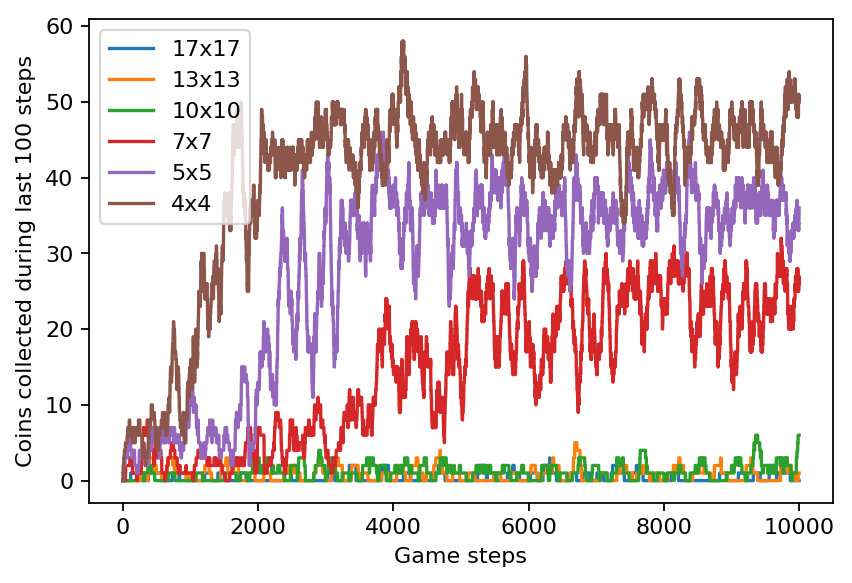

In [766]:
plot_performance(performance['dense64'])

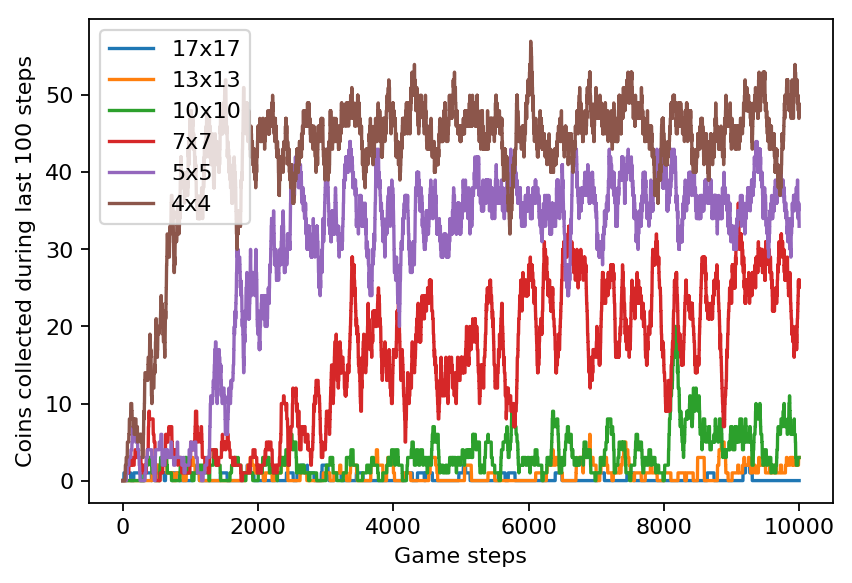

In [767]:
plot_performance(performance['dense256'])

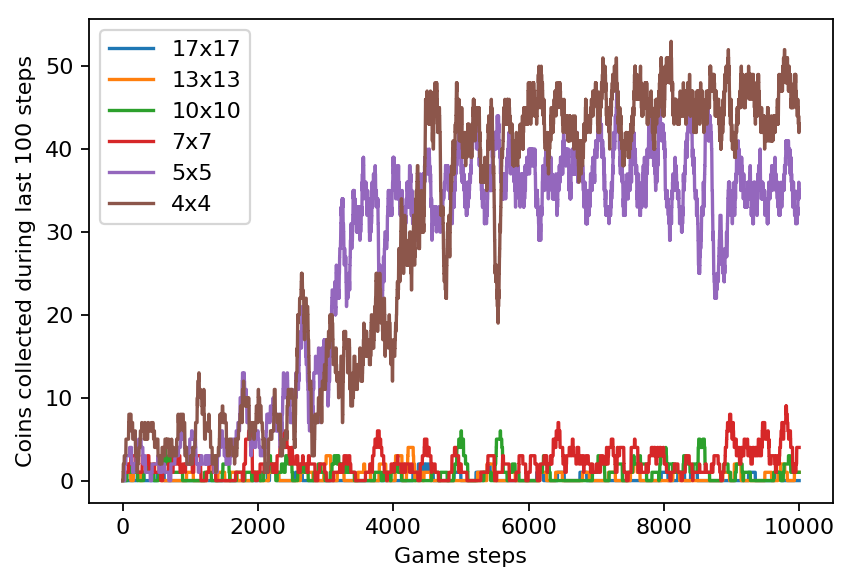

In [763]:
plot_performance(performance['conv843'])

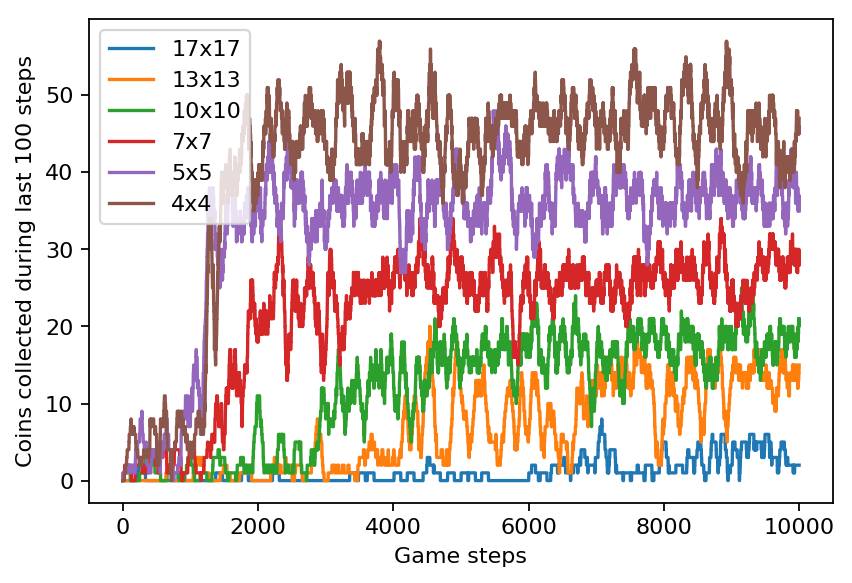

In [764]:
plot_performance(performance['conv143'])

In [755]:
performance[f'{arena_shape[0]}x{arena_shape[1]}-modified-discount0.9'] = coins_found

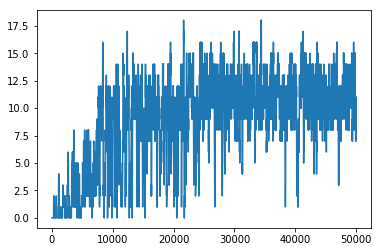

In [715]:
plt.plot(coins_found)

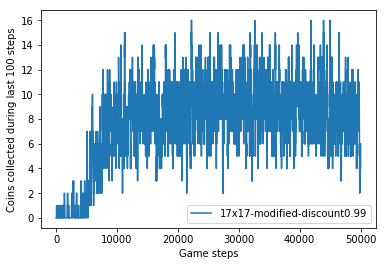

In [412]:
from matplotlib.pyplot import figure
#figure(num=None, dpi=160, facecolor='w', edgecolor='k')

for k, p in performance.items():
    plt.plot(p, label=k)

plt.legend()
plt.ylabel('Coins collected during last 100 steps')
plt.xlabel('Game steps')
plt.show()

In [260]:
#performance64arch = performance
#performance256arch = performance
#performanceconv843arch = performance
#performanceconv143arch = performance

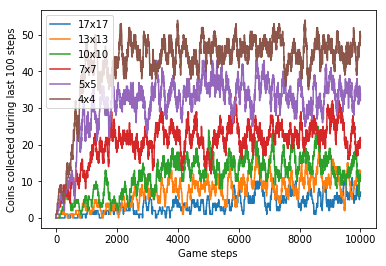

In [177]:
from matplotlib.pyplot import figure
#figure(num=None, dpi=160, facecolor='w', edgecolor='k')

for k, p in performance256arch.items():
    plt.plot(p, label=k)

plt.legend()
plt.ylabel('Coins collected during last 100 steps')
plt.xlabel('Game steps')
plt.show()

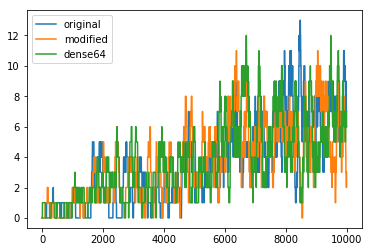

In [271]:
plt.plot(performanceconv843arch['17x17'], label='original')
plt.plot(performanceconv143arch['17x17'], label='modified')
plt.plot(performance256arch['17x17'], label='dense64')
plt.legend()

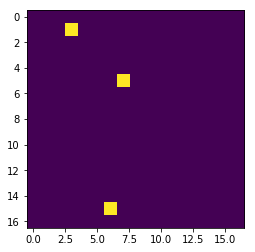

In [716]:
game = Game(*Game.create_arena(arena_shape, agents.keys(), coin_count=3))
plt.imshow(game.coins)
imgs = []

15 6
[-0.4198908  -0.38800883 -0.37452635 -0.386143   -0.33701634 -0.27996364]
[1.         1.03188193 1.04536438 1.03374779 0.         0.        ]
UP {'tensor_agent': 0}


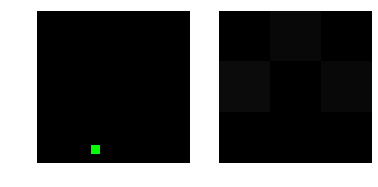

In [746]:
actions = {}
Xs = {}
c = np.copy(game.coins)
for agent in game.agents:
    x, y, name, _, _ = agent

    Xs[name] = game.get_X(x, y)
    valid_actions = get_valid_actions(x, y, game)
    
    print(x, y)
    pred = agents[name].model.online.predict(np.array([Xs[name]]))[0]
    print(pred)
    if valid_actions is not None:
        pred = valid_actions * (pred - np.min(pred) + 1)

    print(pred)
    action_choice = np.argmax(pred)
            
    actions[name] = action_choice

actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
#actions_as_string['tensor_agent'] = 'RIGHT'
rewards = game.step(actions_as_string)

print(actions_as_string['tensor_agent'], rewards)

#img = np.zeros((input_shape[0], input_shape[1], 3))
#img[:,:,0] = Xs['tensor_agent'][:,:,0]
#img[arena_shape[0]-1,arena_shape[1]-1,1] = 1

img = np.zeros((arena_shape[0], arena_shape[0], 3))
img[:,:,0] = c
img[x,y,1] = 1


choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
choice_dict = {choices[i]: i for i in range(len(choices))}

a = np.zeros((3, 3))
a[2, 1] = pred[choice_dict['RIGHT']]
a[0, 1] = pred[choice_dict['LEFT']]
a[1, 0] = pred[choice_dict['UP']]
a[1, 2] = pred[choice_dict['DOWN']]
a[1, 1] = pred[choice_dict['WAIT']]
a[0, 0] = pred[choice_dict['BOMB']]

#a = np.exp(a) / np.sum(np.exp(a), axis=0)
a = np.log(a + 0.0001)
a[a == -np.inf] = 0

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
ax2.axis('off')
ax2.imshow(a, cmap='gray', vmin=0, vmax=1)
ax1.imshow(img)
imgs.append(img)

In [56]:
game.agents[0] = (0,2,'tensor_agent',1,0)

In [87]:

def animation(imgs, r, c, steps, interval=50):
    import matplotlib.animation
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

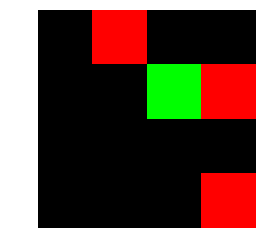

In [89]:
r,c,steps = 1,2,len(imgs)  # number of rows, columns and steps to walk in latent space
anim = animation(imgs,r,c,steps, interval=300)
HTML(anim.to_jshtml())

In [8]:
pred, grd = K.get_session().run([model.t_out, grads], feed_dict={
            model.input_ph: np.array([Xs['tensor_agent']])
        })

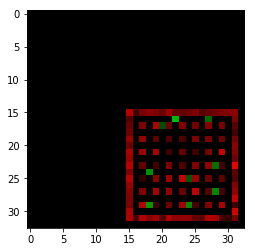

In [21]:
img0 = grd[0][0][:,:,0:1]
img0 = img0 - np.min(img0)
img0 = img0 / np.max(img0)

img1 = grd[0][0][:,:,1:2]
img1 = img1 - np.min(img1)
img1 = img1 / np.max(img1)

img5 = grd[0][0][:,:,5:6]
img5 = img5 - np.min(img5)
img5 = img5 / np.max(img5)

inp = Xs['tensor_agent'][:,:,[0,5,1]]
img = np.concatenate([img0, img5, img1], axis=2)


plt.imshow(img * inp)

In [6]:
class FrozenLake:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names):
        lake = np.zeros(shape)
        xs = np.random.choice(shape[0], 1)
        ys = np.random.choice(shape[1], 1)
        
        lake[xs, ys] = 1
        
        while np.min(lake) > -1:
            xs = np.random.choice(shape[0], 1)
            ys = np.random.choice(shape[1], 1)
            if lake[xs, ys] != 1:
                lake[xs, ys] = -1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [lake, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 40:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    